In [1]:
# put the directory path to your LMR repository here
import sys
sys.path.append("/Users/dan/Desktop/LMR_py3/")
#!cd /Users/dan/Desktop/LMR_py3

# prefix for figure filename
#fig_prefix='prior_truth_'

In [2]:
import os
os.chdir('/Users/dan/Desktop/LMR_py3')
import LMR_lite_utils as LMRlite
import LMR_utils
import LMR_config
import numpy as np
import os,sys
from time import time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
%matplotlib inline
import cartopy.util as cutil
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.cm as cm



Loading information from datasets.yml
Loading information from grid_def.yml


In [4]:
# use this when revising modules; this reloads
import importlib
importlib.reload(LMRlite)
importlib.reload(LMR_config)

Loading information from datasets.yml
Loading information from grid_def.yml


<module 'LMR_config' from '/Users/dan/Desktop/LMR_py3/LMR_config.py'>

In [4]:
# load proxies
lmr_names = ['ccsm3_trace21ka',
             'icesm_lgm2present']
cfile = './configs/config.yml.nullspace.'+lmr_names[0]
yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
cfg = LMRlite.load_config(yaml_file)

prox_manager = LMRlite.load_proxies(cfg)
numprox = len(prox_manager.all_proxies)

Checking configuration ... 
OK!
                        Marine sediments_uk37 :   101
                                        TOTAL :   101
-----------------------------------------------------
completed in 56.074544191360474 seconds
-----------------------------------------------------


In [4]:
# Load and interpolate all of the priors I want to use as truth

lmr_names = ['ccsm3_trace21ka',
             'icesm_lgm2present']
model_names = ['trace','icesm']

# Initialize an array of various interpolated model fields
ad = []

for ii in np.arange(len(lmr_names)):
    dd = {}
    cfile = './configs/config.yml.nullspace.'+lmr_names[ii]
    yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
    cfg = LMRlite.load_config(yaml_file)
    
    X, Xb_one = LMRlite.load_prior(cfg)
    Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)
    
    # check if config is set to regrid the prior
    if cfg.prior.regrid_method:
        print('regridding prior...')
        # this function over-writes X, even if return is given a different name
        [X,Xb_one_new] = LMRlite.prior_regrid(cfg,X,Xb_one,verbose=False)
    else:
        X.trunc_state_info = X.full_state_info
    
    Xb_one = Xb_one_new
    Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)
    grid = LMRlite.Grid(X)    
    
    dd['X']        = X
    dd['Xbp']      = Xbp
    dd['name']     = model_names[ii]
    dd['lmr_name'] = lmr_names[ii]
    dd['grid']     = grid

    print(ii)
    print(dd['name'])

    ad.append(dd)
        


Checking configuration ... 
OK!
Reading file:  /Users/dan/Desktop/LMR_py3/data/model/ccsm3_trace21ka/tas_sfc_Adec_CCSM3_TraCE21ka.nc
:: Data temporal resolution =  10.0 yrs
Array dims : ('time', 'lat', 'lon')
Array shape: (2204, 48, 96)
Type of variable: 2D:horizontal
indlat(orig)= 1  indlon(orig)= 2
indlat      = 0  indlon      = 1
Full field provided as the prior
tas : Global: mean= 272.15344  , std-dev= 22.453375
Averaging period (years): 200
tas : Global(time-averaged): mean= 272.14795  , std-dev= 22.453724
 
State vector information:
Nx = 4608
state_vect_info= {'tas_sfc_Adec': {'pos': (0, 4607), 'spacecoords': ('lat', 'lon'), 'spacedims': (48, 96), 'vartype': '2D:horizontal'}}
Random selection of 75 ensemble members
regridding prior...
tas_sfc_Adec  : 2D lat/lon variable, truncating this variable
=> Full array:      206.0719451904297 300.7749938964844 272.23253937301814 22.38401235078546
=> Truncated array: 206.27301443045636 300.34712174509843 271.84883401553634 22.55938338601423

SystemExit: 

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2969: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [9]:
def mk_pproxies(X,Xbp,prox_manager,SNR,grid):

    """
    Construct pseudoproxies 
    """

    numprox = len(prox_manager.ind_assim)

    vY = np.zeros([numprox,grid.nens])
    vR = []
    vP = []

    for proxy_idx, Y in enumerate(prox_manager.sites_assim_proxy_objs()):
        # get grid indices
        tmp = grid.lat[:,0]-Y.lat
        itlat = np.argmin(np.abs(tmp))
        tmp = grid.lon[0,:]-Y.lon
        itlon = np.argmin(np.abs(tmp))
        npos = itlat*grid.nlon + itlon

        # Noise amplitude corresponding to SNR by stdev
        sig = np.std(Xbp[npos,:])
        #print(sig)
        #print(sig/SNR)
        # Make pproxies
        vY[proxy_idx,:] = Xbp[npos,:] + np.random.randn(grid.nens,)*sig/SNR
        vR.append((sig/SNR)**2)
        vP.append(proxy_idx)

    return vY, vR, vP

def mk_yes(X,Xbp,prox_manager,grid):

    vYe = np.zeros([numprox,grid.nens])
    vYe_coords = np.zeros([numprox,2])

    for proxy_idx, Y in enumerate(prox_manager.sites_assim_proxy_objs()):
        # get grid indices
        tmp = grid.lat[:,0]-Y.lat
        itlat = np.argmin(np.abs(tmp))
        tmp = grid.lon[0,:]-Y.lon
        itlon = np.argmin(np.abs(tmp))
        npos = itlat*grid.nlon + itlon
        # the ensemble prior estimates
        vYe[proxy_idx,:] = Xbp[npos,:]
        vYe_coords[proxy_idx,:] = X.coords[npos,:]

    return vYe, vYe_coords


In [10]:
# Compare what happens for various truth-prior pairs
# Things to include: localization, SNR, ob network

def process_input(SNR):

    LOCRADs = [2000.]
    NENS = grid.nens
    # for testing
    # NENS = 2

    for hh in np.arange(len(LOCRADs)):

        LOCRAD = LOCRADs[hh]

        # Initialize array of dictionaries containing the different comparisons
        cdd = []

        # Loop over prior files
        for ii in np.arange(len(lmr_names)):

            # Load the config file corresponding to the iith prior
            cfile = './configs/config.yml.nullspace.'+lmr_names[ii]
            yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
            cfg = LMRlite.load_config(yaml_file)

            # Compute effective observations
            vYe, vYe_coords = mk_yes(ad[ii]['X'],ad[ii]['Xbp'],prox_manager,ad[ii]['grid'])

            # change the localization radius in the config file
            cfg_params = LMR_utils.param_cfg_update('core.loc_rad',LOCRAD)
            cfg_new = LMR_config.Config(**cfg_params)

            # Loop over truth files
            for jj in np.arange(len(lmr_names)):

                # Use a precomputed interpolated version of the truth
                vY, vR, vP = mk_pproxies(ad[jj]['X'],ad[jj]['Xbp'],prox_manager,SNR,ad[jj]['grid'])

                fp = np.empty([ad[ii]['grid'].nlon*ad[ii]['grid'].nlat,NENS])

                # Loop over ensemble members
                for kk in np.arange(NENS):
                    if LOCRAD==0.:
                        f,Xap,_ = LMRlite.Kalman_optimal(vY[:,kk],vR,vYe,ad[ii]['Xbp'],verbose=False)
                    else:
                        f,Xap2 = LMRlite.Kalman_ESRF(cfg_new,vY[:,kk],vR,vYe,ad[ii]['Xbp'],X=ad[ii]['X'],vYe_coords=vYe_coords,verbose=False)

                    fp[:,kk] = f

                # Store information in a dictionary for this prior-truth pair
                c = {}
                c['locrad']     = LOCRAD
                c['snr']        = SNR
                c['prior_name'] = ad[ii]['name']
                c['truth_name'] = ad[jj]['name']
                c['pind']       = ii
                c['tind']       = jj
                c['recon']      = fp
                c['rmse']       = np.mean((ad[jj]['Xbp'][:,:NENS]-fp)**2,1)**.5

                # Concatenate the dictionary to a list corresponding to all prior-truth pairs 
                # for the choices of LOCRAD and SNR
                cdd.append(c)

        # Save all prior-truth pairs for these choices of LOCRAD and SNR
        print('saving for LOCRAD = '+ str(LOCRAD) + ' and SNR = '+ str(SNR))
        np.save('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_' + str(LOCRAD)+ '_snr_' + str(SNR),cdd)
    print('Done!')        

In [ ]:
# Run in parallel
SNRs = [100.,0.4]

from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
nj = len(SNRs)
Parallel(n_jobs=nj)(delayed(process_input)(SNRs[i]) for i in np.arange(nj))

In [13]:
# Plot RMS error

def plt_rmse(cdd,title):

    import cartopy.util as cutil
    import cartopy.crs as ccrs
    from cartopy.mpl.geoaxes import GeoAxes
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    from mpl_toolkits.axes_grid1 import AxesGrid
    import matplotlib.cm as cm

    projection = ccrs.PlateCarree(central_longitude=0.)
    axes_class = (GeoAxes,
                  dict(map_projection=projection))

    fig = plt.figure(figsize=(16,12))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(3, 3),
                    axes_pad=0.6,
                    cbar_location='right',
    #               cbar_mode='each',
                    cbar_mode='single',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    cbar_set_cax=False,
                    label_mode='')  # note the empty label_mode

    for ii, ax in enumerate(axgr):

        rmsc = cdd[ii]['rmse']

        cldat = rmsc.reshape(grid.nlat,grid.nlon)
        wrap_data, wrap_lon = cutil.add_cyclic_point(cldat, coord=grid.lon[0,:], axis=1)

        plt.sca(axgr[ii])
        p=plt.pcolormesh(wrap_lon,grid.lat[:,0],wrap_data,vmax=2.0,vmin=0.,
                        transform=projection,
                        cmap='YlOrRd',
                        )

        ax.coastlines(color='gray')
        if cdd[ii]['pind']==2:
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax.xaxis.set_major_formatter(lon_formatter)
            ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)

        if cdd[ii]['tind'] == 0:
            ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
            lat_formatter = LatitudeFormatter()
            ax.yaxis.set_major_formatter(lat_formatter)

        #plt.title('Prior: '+ cdd[ii]['prior_name'] + ', truth: ' + cdd[ii]['truth_name'])
        
    cb=axgr.cbar_axes[0].colorbar(p)
    fig.suptitle(title, fontsize=14)
#    plt.tight_layout
    #plt.show();


100.0


/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/dan/anaconda2/envs/lmr_py3/lib/pyth

1.0


/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


0.4


/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


0.1


/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


0.001


/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

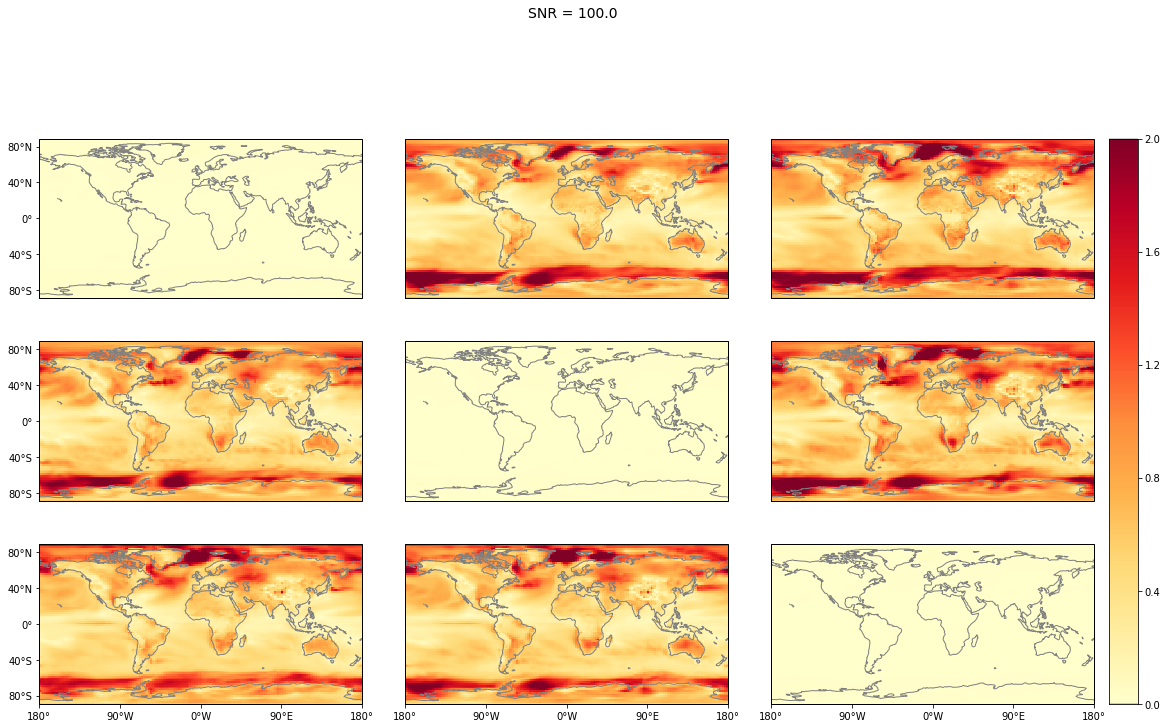

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


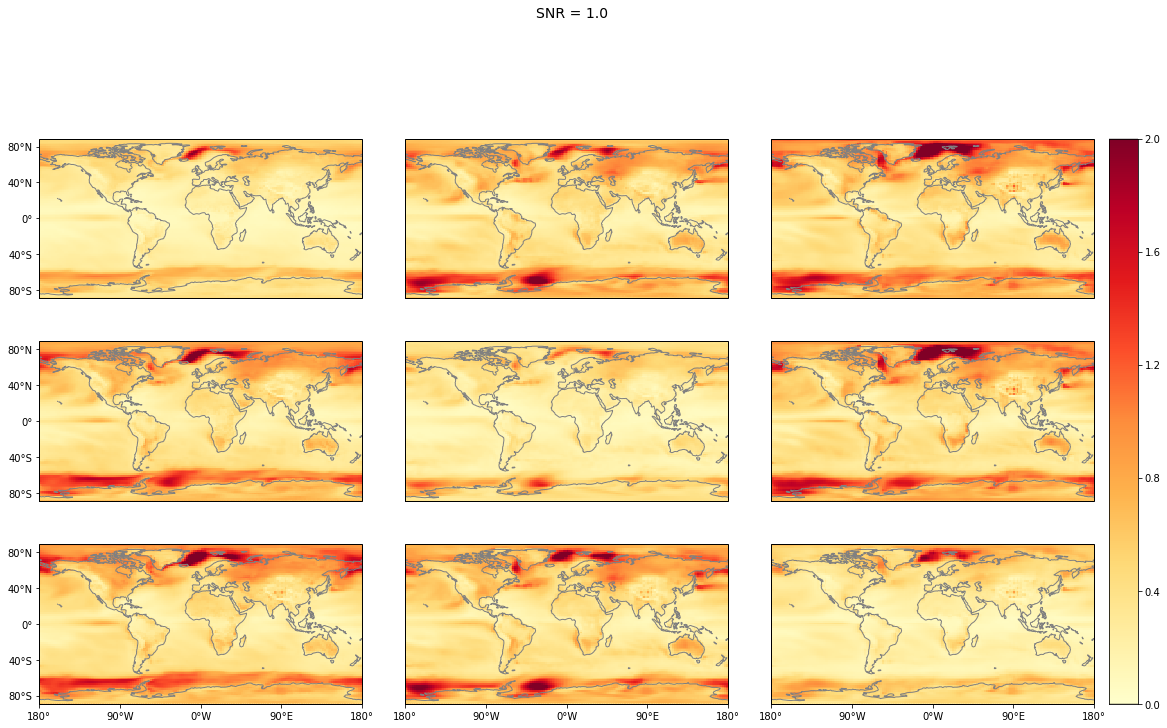

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


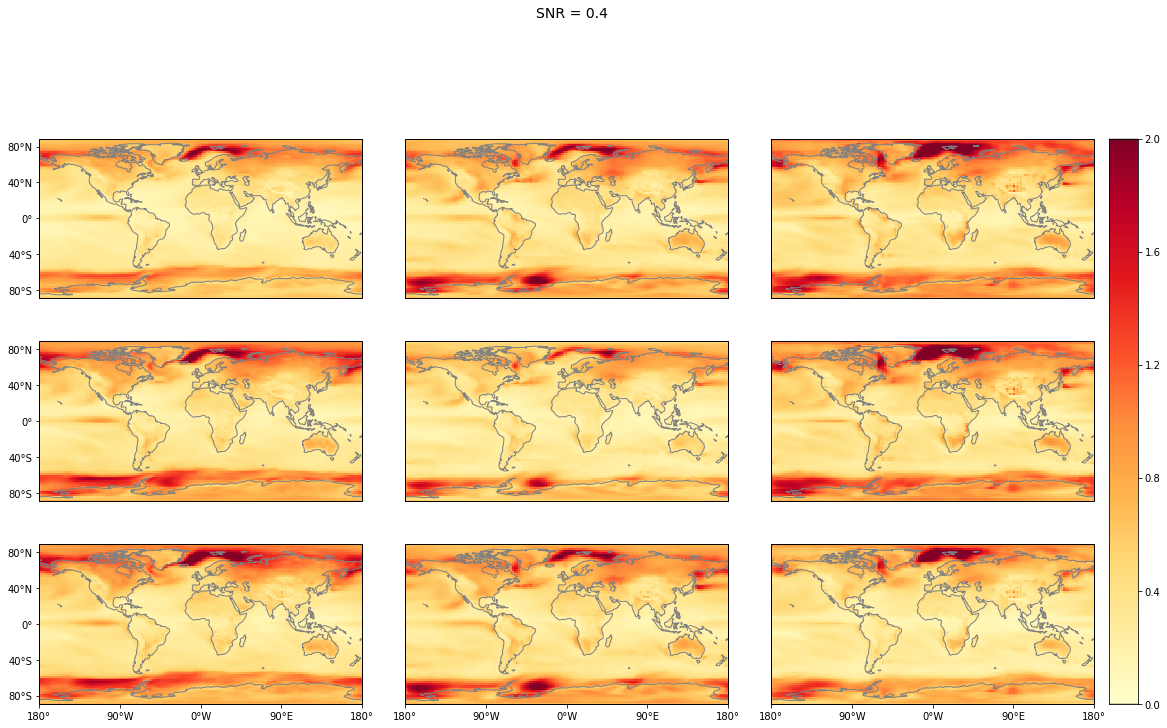

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


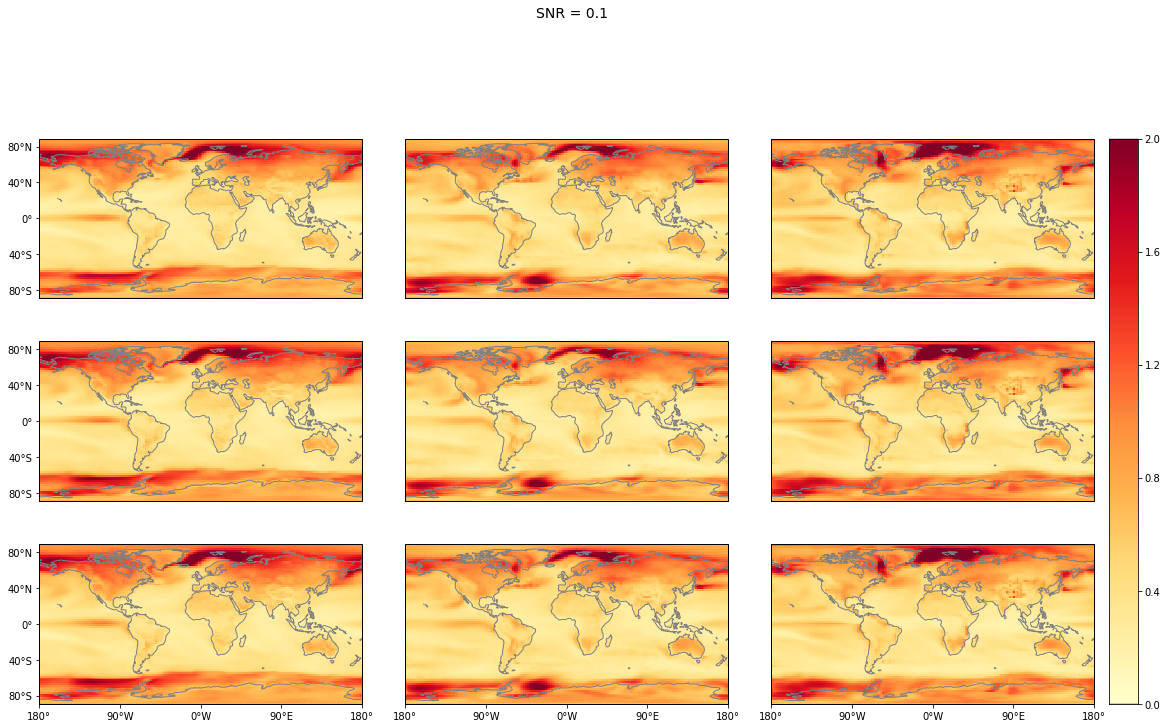

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


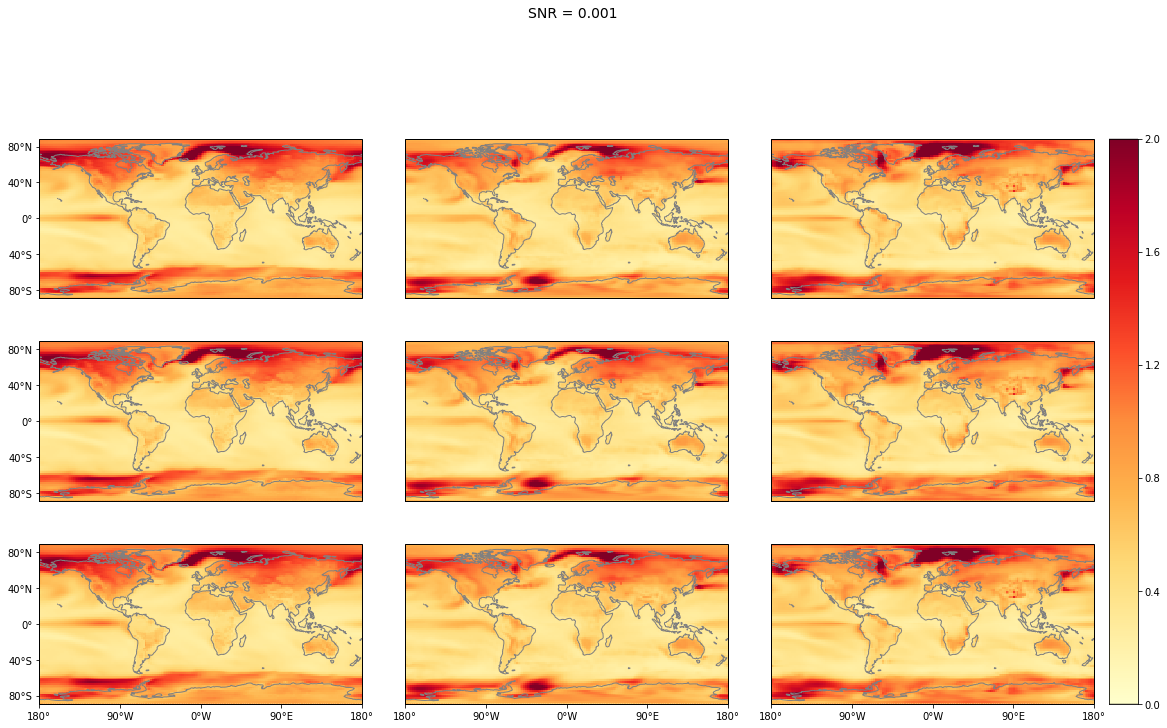

In [349]:
# Plot rmses for all SNRs

SNRs = [100.0,1.,0.4,0.1,0.001]

for _,SNR in enumerate(SNRs):
    print(SNR)
    
    cdd=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_0.0_snr_'+str(SNR)+'.npy')
    title = 'SNR = '+str(SNR)
    plt_rmse(cdd,title)
    plt.savefig('/Users/dan/Desktop/Nullspace_Figs/pt_figs/basic_'+str(SNR)+'.png',bbox_inches='tight',dpi=300)
    plt.show()

100.0


/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


0.4


/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


0.001


/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

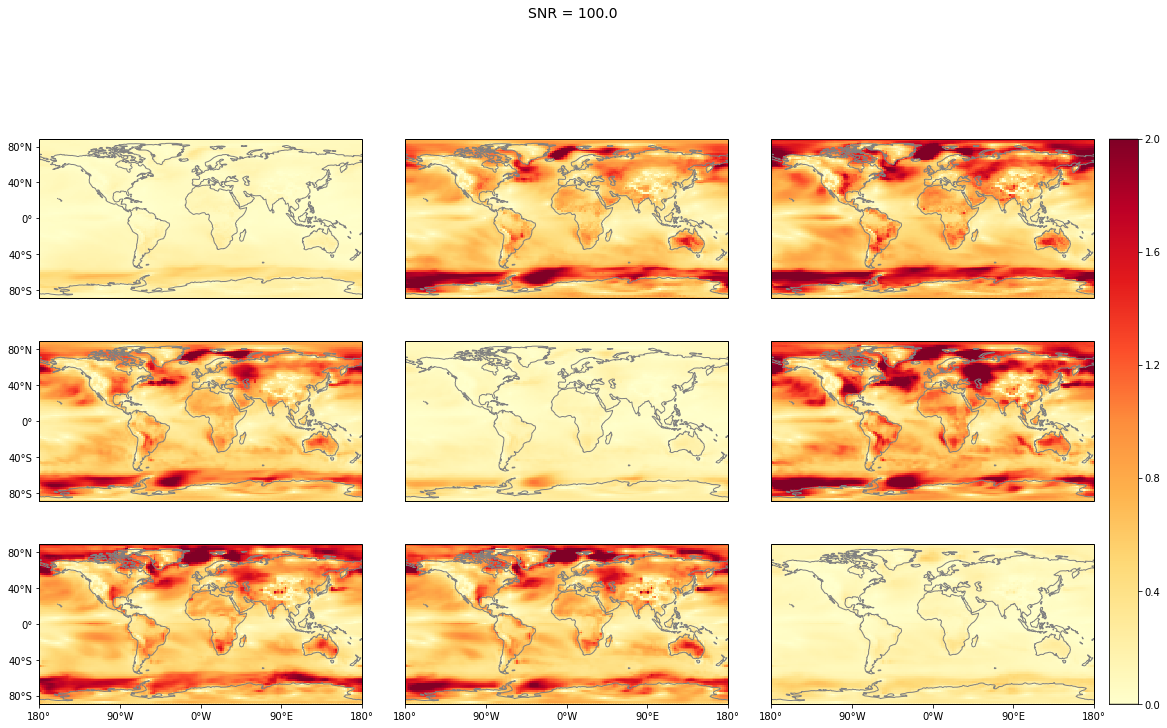

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


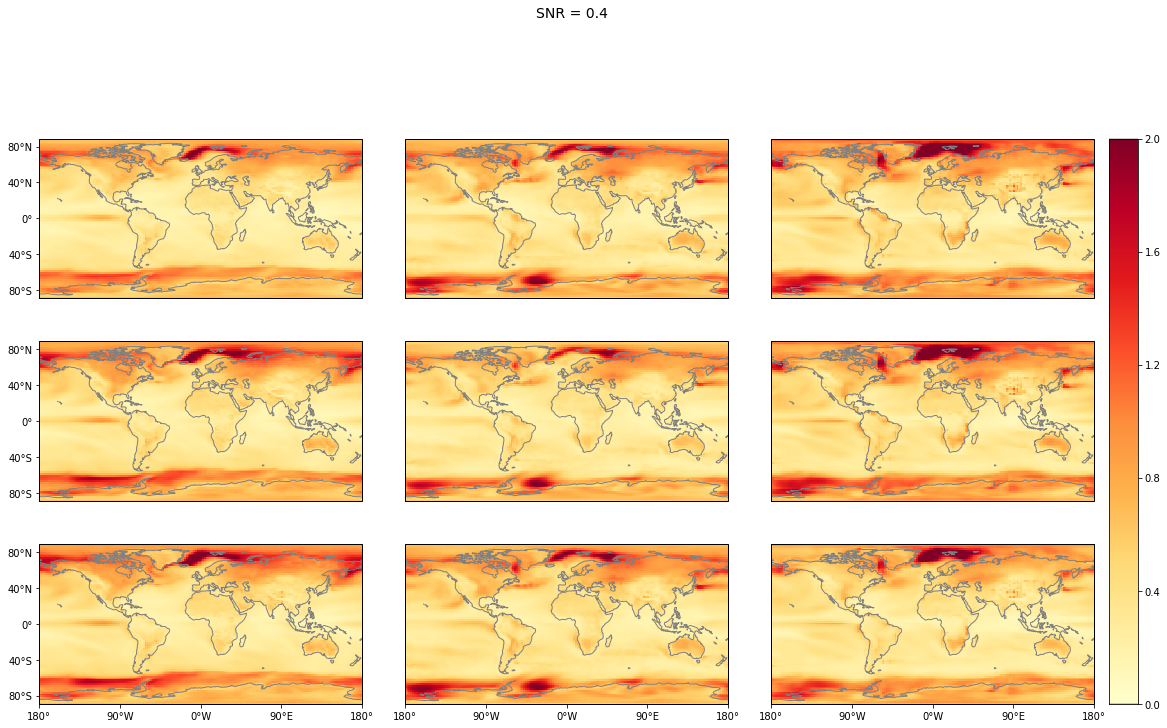

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


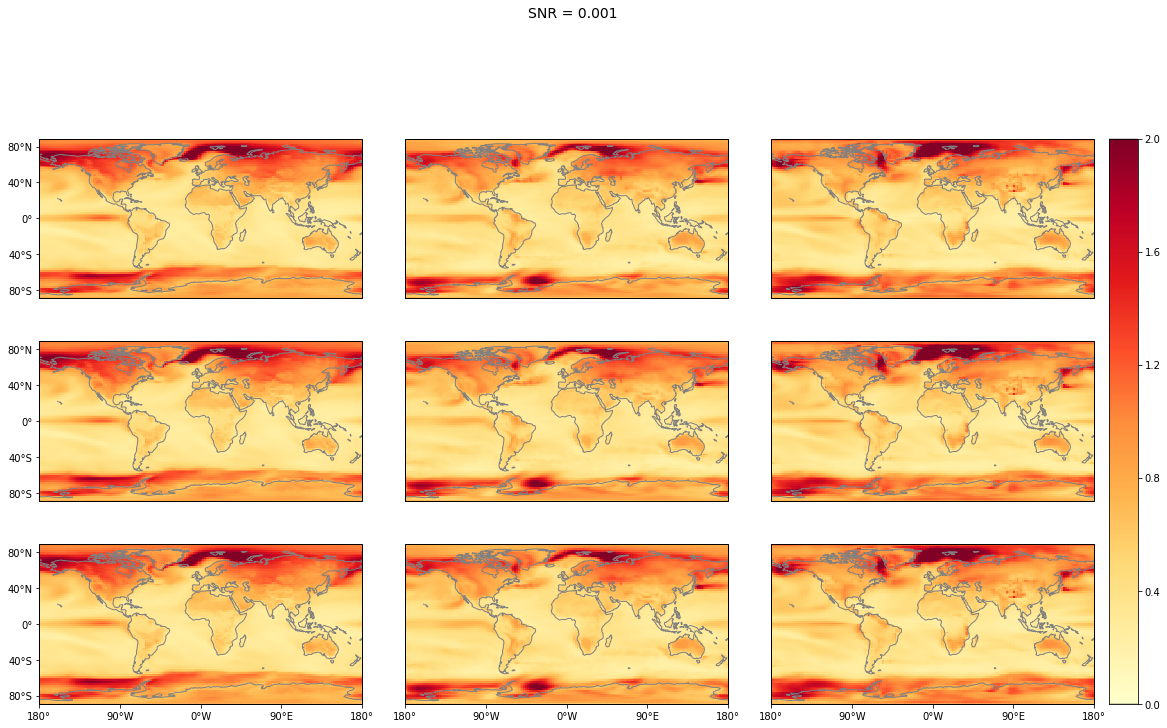

In [344]:
# Plot rmses for all SNRs
# LOCRAD=25000.

SNRs = [100.0,0.4,0.001]

for _,SNR in enumerate(SNRs):
    print(SNR)
    
    cdd=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_25000.0_snr_'+str(SNR)+'.npy')
    title = 'SNR = '+str(SNR)
    plt_rmse(cdd,title)
    plt.savefig('/Users/dan/Desktop/Nullspace/pt_figs/basic_'+str(SNR)+'.png',dpi=300)

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


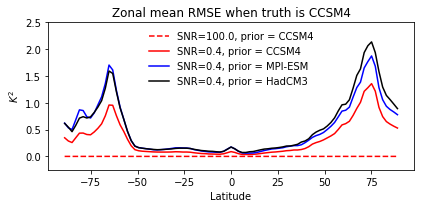

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


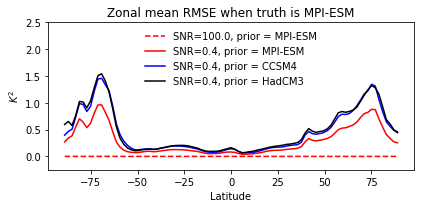

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


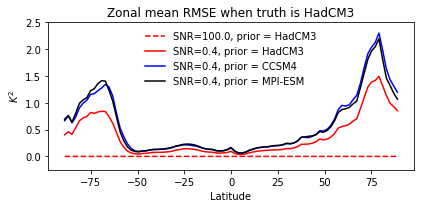

In [329]:
# Zonal means plot

# Goal: For each model truth, plot zonal mean RMSE for sparsity, sparsity + noise, sparsity + noise + prior error

# First: noise-free
SNR = '0.4'
cdd100=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_0.0_snr_100.0.npy')
cdd4=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_0.0_snr_'+SNR+'.npy')

lat = ad[0]['grid'].lat[:,0]

key = np.array([[0,3,6],[4,1,7],[8,2,5]])

for ii in np.arange(3):
    fig = plt.figure(figsize=(6,3))
    plt.plot(lat,np.mean(cdd100[key[ii,0]]['rmse'].reshape([91,180])**2,1),'r--')
    #plt.plot(lat,np.mean(cdd100[key[ii,1]]['rmse'].reshape([91,180])**2,1),'b--')
    #plt.plot(lat,np.mean(cdd100[key[ii,2]]['rmse'].reshape([91,180])**2,1),'k--')
    plt.plot(lat,np.mean(cdd4[key[ii,0]]['rmse'].reshape([91,180])**2,1),'r')
    plt.plot(lat,np.mean(cdd4[key[ii,1]]['rmse'].reshape([91,180])**2,1),'b')
    plt.plot(lat,np.mean(cdd4[key[ii,2]]['rmse'].reshape([91,180])**2,1),'k')
    #plt.tight_layout()
    plt.ylabel('$K^2$')
    plt.ylim([-0.25,2.5])
    plt.xlabel('Latitude')
    plt.title('Zonal mean RMSE when truth is '+cdd100[key[ii,0]]['truth_name'])
    plt.legend(['SNR=100.0, prior = '+cdd100[key[ii,0]]['prior_name'],
                #'SNR=100.0, prior = '+cdd100[key[ii,1]]['prior_name'],
                #'SNR=100.0, prior = '+cdd100[key[ii,2]]['prior_name'],
                'SNR='+SNR+', prior = '+cdd100[key[ii,0]]['prior_name'],
                'SNR='+SNR+', prior = '+cdd100[key[ii,1]]['prior_name'],
                'SNR='+SNR+', prior = '+cdd100[key[ii,2]]['prior_name']
               ],loc='upper center',frameon=False)
    plt.show();



/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


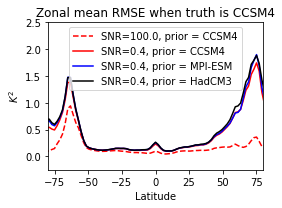

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


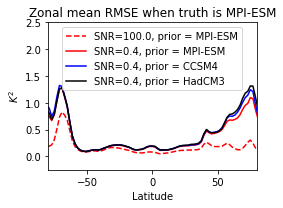

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


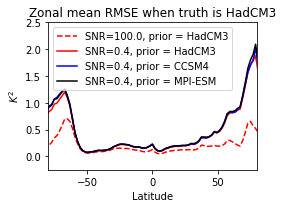

In [354]:
# Zonal means plot
#LOCRAD=5000

# Goal: For each model truth, plot zonal mean RMSE for sparsity, sparsity + noise, sparsity + noise + prior error

# First: noise-free
SNR = '0.4'
cdd100=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_5000.0_snr_100.0.npy')
cdd4=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_5000.0_snr_'+SNR+'.npy')

lat = ad[0]['grid'].lat[:,0]

key = np.array([[0,3,6],[4,1,7],[8,2,5]])

for ii in np.arange(3):
    fig = plt.figure(figsize=(4,3))
    plt.plot(lat,np.mean(cdd100[key[ii,0]]['rmse'].reshape([91,180])**2,1),'r--')
    #plt.plot(lat,np.mean(cdd100[key[ii,1]]['rmse'].reshape([91,180])**2,1),'b--')
    #plt.plot(lat,np.mean(cdd100[key[ii,2]]['rmse'].reshape([91,180])**2,1),'k--')
    plt.plot(lat,np.mean(cdd4[key[ii,0]]['rmse'].reshape([91,180])**2,1),'r')
    plt.plot(lat,np.mean(cdd4[key[ii,1]]['rmse'].reshape([91,180])**2,1),'b')
    plt.plot(lat,np.mean(cdd4[key[ii,2]]['rmse'].reshape([91,180])**2,1),'k')
    plt.ylabel('$K^2$')
    plt.ylim([-0.25,2.5])
    plt.xlim([-80,80])
    plt.xlabel('Latitude')
    plt.title('Zonal mean RMSE when truth is '+cdd100[key[ii,0]]['truth_name'])
    plt.legend(['SNR=100.0, prior = '+cdd100[key[ii,0]]['prior_name'],
                #'SNR=100.0, prior = '+cdd100[key[ii,1]]['prior_name'],
                #'SNR=100.0, prior = '+cdd100[key[ii,2]]['prior_name'],
                'SNR='+SNR+', prior = '+cdd100[key[ii,0]]['prior_name'],
                'SNR='+SNR+', prior = '+cdd100[key[ii,1]]['prior_name'],
                'SNR='+SNR+', prior = '+cdd100[key[ii,2]]['prior_name']
               ])
    plt.tight_layout()
    plt.show();



In [545]:
# Zonal means plot
#LOCRAD=10000

# Goal: For each model truth, plot zonal mean RMSE for sparsity, sparsity + noise, sparsity + noise + prior error

# First: noise-free
SNR = '0.4'
#LOCRADs = ['2000.0', '5000.0', '10000.0', '25000.0']
LOCRADs = ['0.0','25000.0','10000.0','5000.0','2000.0']
lat = ad[0]['grid'].lat

#gm = np.empty([9,len(LOCRADs)])

gmp = pd.DataFrame(columns=['gmv','LOCRAD','LOCind','prior_name','truth_name'])
for ii,LOCRAD in enumerate(LOCRADs):

    cdd4=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_' + LOCRAD + '_snr_' + SNR + '.npy')

    for jj in np.arange(len(cdd4)):
      
        #gm[jj,ii] = np.sum(np.cos(np.deg2rad(lat.ravel()))*cdd4[jj]['rmse'])/np.sum(np.cos(np.deg2rad(lat)))
        gm = np.sum(np.cos(np.deg2rad(lat.ravel()))*cdd4[jj]['rmse'])/np.sum(np.cos(np.deg2rad(lat)))
        ne = [gm,LOCRAD,cdd4[jj]['prior_name'],cdd4[jj]['truth_name']]
#                          ,columns=['gmv','LOCRAD','prior_name','truth_name'])
        nee = pd.DataFrame({"gmv":[gm],
                            "LOCRAD":LOCRAD,
                            "LOCind":ii,
                            "prior_name":cdd4[jj]['prior_name'],
                            "truth_name":cdd4[jj]['truth_name']                            
                           })
        gmp=gmp.append(nee)




/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


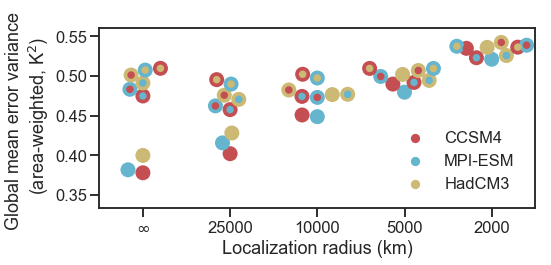

In [546]:
#for ii in np.arange(9):
#    plt.scatter(np.arange(len(LOCRADs)),gm[ii,:],marker='o', facecolors='none',edgecolors='k')


#plt.xticks(np.arange(len(LOCRADs)),['$\infty$','25000','10000','5000'])
#plt.xlabel('Localization radius (km)')
#plt.ylabel('Global mean error variance (area-weighted)')
#plt.show()

import seaborn as sns

#sns.set(style='ticks', context='talk')
#iris = sns.load_dataset('iris')

#pd.DataFrame(gm)
si = 15
fig = plt.figure(figsize=(8,4))
sns.swarmplot(data=gmp,x="LOCind", y="gmv", hue="prior_name",size=si,marker='o',palette=["r", "c", "y"])
ax=sns.swarmplot(data=gmp,x="LOCind", y="gmv", hue="truth_name",size=si,marker='.',palette=["r", "c", "y"])
plt.xticks(np.arange(len(LOCRADs)),['$\infty$','25000','10000','5000','2000'])
plt.xlabel('Localization radius (km)')
plt.ylabel('Global mean error variance \n (area-weighted, K$^2$)')
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(.67, .47), loc=2, borderaxespad=0.,frameon=False)
plt.tight_layout
plt.savefig('/Users/dan/Desktop/Nullspace_Figs/evar_vs_LOCRAD.pdf')


/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


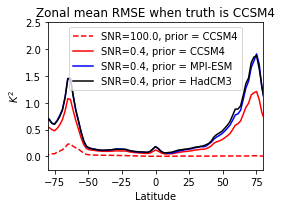

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


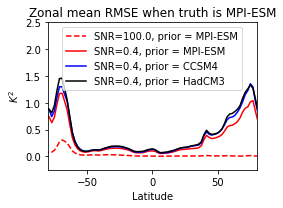

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


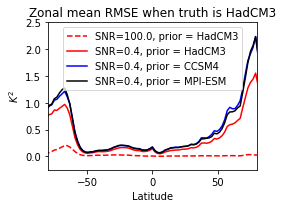

In [356]:
# Zonal means plot
#LOCRAD=25000

# Goal: For each model truth, plot zonal mean RMSE for sparsity, sparsity + noise, sparsity + noise + prior error

# First: noise-free
SNR = '0.4'
cdd100=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_25000.0_snr_100.0.npy')
cdd4=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_25000.0_snr_'+SNR+'.npy')

lat = ad[0]['grid'].lat[:,0]

key = np.array([[0,3,6],[4,1,7],[8,2,5]])

for ii in np.arange(3):
    fig = plt.figure(figsize=(4,3))
    plt.plot(lat,np.mean(cdd100[key[ii,0]]['rmse'].reshape([91,180])**2,1),'r--')
    #plt.plot(lat,np.mean(cdd100[key[ii,1]]['rmse'].reshape([91,180])**2,1),'b--')
    #plt.plot(lat,np.mean(cdd100[key[ii,2]]['rmse'].reshape([91,180])**2,1),'k--')
    plt.plot(lat,np.mean(cdd4[key[ii,0]]['rmse'].reshape([91,180])**2,1),'r')
    plt.plot(lat,np.mean(cdd4[key[ii,1]]['rmse'].reshape([91,180])**2,1),'b')
    plt.plot(lat,np.mean(cdd4[key[ii,2]]['rmse'].reshape([91,180])**2,1),'k')
    plt.ylabel('$K^2$')
    plt.ylim([-0.25,2.5])
    plt.xlim([-80,80])
    plt.xlabel('Latitude')
    plt.title('Zonal mean RMSE when truth is '+cdd100[key[ii,0]]['truth_name'])
    plt.legend(['SNR=100.0, prior = '+cdd100[key[ii,0]]['prior_name'],
                #'SNR=100.0, prior = '+cdd100[key[ii,1]]['prior_name'],
                #'SNR=100.0, prior = '+cdd100[key[ii,2]]['prior_name'],
                'SNR='+SNR+', prior = '+cdd100[key[ii,0]]['prior_name'],
                'SNR='+SNR+', prior = '+cdd100[key[ii,1]]['prior_name'],
                'SNR='+SNR+', prior = '+cdd100[key[ii,2]]['prior_name']
               ])
    plt.tight_layout()
    plt.show();



/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


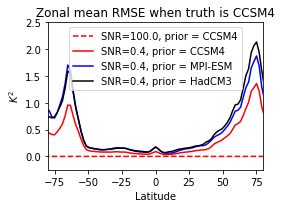

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


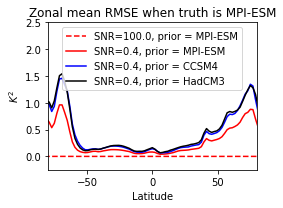

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


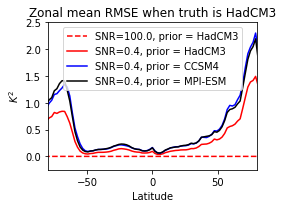

In [357]:
# Zonal means plot
#LOCRAD=0

# Goal: For each model truth, plot zonal mean RMSE for sparsity, sparsity + noise, sparsity + noise + prior error

# First: noise-free
SNR = '0.4'
cdd100=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_0.0_snr_100.0.npy')
cdd4=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_0.0_snr_'+SNR+'.npy')

lat = ad[0]['grid'].lat[:,0]

key = np.array([[0,3,6],[4,1,7],[8,2,5]])

for ii in np.arange(3):
    fig = plt.figure(figsize=(4,3))
    plt.plot(lat,np.mean(cdd100[key[ii,0]]['rmse'].reshape([91,180])**2,1),'r--')
    #plt.plot(lat,np.mean(cdd100[key[ii,1]]['rmse'].reshape([91,180])**2,1),'b--')
    #plt.plot(lat,np.mean(cdd100[key[ii,2]]['rmse'].reshape([91,180])**2,1),'k--')
    plt.plot(lat,np.mean(cdd4[key[ii,0]]['rmse'].reshape([91,180])**2,1),'r')
    plt.plot(lat,np.mean(cdd4[key[ii,1]]['rmse'].reshape([91,180])**2,1),'b')
    plt.plot(lat,np.mean(cdd4[key[ii,2]]['rmse'].reshape([91,180])**2,1),'k')
    plt.ylabel('$K^2$')
    plt.ylim([-0.25,2.5])
    plt.xlim([-80,80])
    plt.xlabel('Latitude')
    plt.title('Zonal mean RMSE when truth is '+cdd100[key[ii,0]]['truth_name'])
    plt.legend(['SNR=100.0, prior = '+cdd100[key[ii,0]]['prior_name'],
                #'SNR=100.0, prior = '+cdd100[key[ii,1]]['prior_name'],
                #'SNR=100.0, prior = '+cdd100[key[ii,2]]['prior_name'],
                'SNR='+SNR+', prior = '+cdd100[key[ii,0]]['prior_name'],
                'SNR='+SNR+', prior = '+cdd100[key[ii,1]]['prior_name'],
                'SNR='+SNR+', prior = '+cdd100[key[ii,2]]['prior_name']
               ])
    plt.tight_layout()
    plt.show();



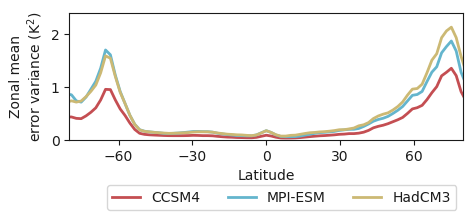

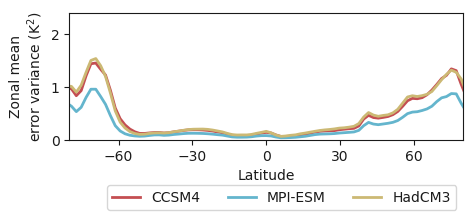

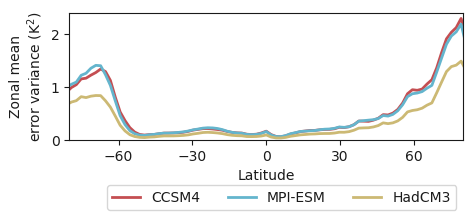

In [618]:
# Global means plot

# Goal: For each model truth, plot zonal mean RMSE for sparsity, sparsity + noise, sparsity + noise + prior error

# First: noise-free
importlib.reload(plt)
plt.style.use('default')
#sns.set(style='ticks', context='talk')
SNR = '0.4'

cdd4=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_0.0_snr_'+SNR+'.npy')

lat = ad[0]['grid'].lat[:,0]

#key = np.array([[0,3,6],[4,1,7],[8,2,5]])
key = np.array([[0,3,6],[1,4,7],[2,5,8]])


for ii in np.arange(3):
    fig = plt.figure(figsize=(5,2.5))
    #plt.plot(lat,np.mean(cdd100[key[ii,0]]['rmse'].reshape([91,180])**2,1),'r--')
    #plt.plot(lat,np.mean(cdd100[key[ii,1]]['rmse'].reshape([91,180])**2,1),'b--')
    #plt.plot(lat,np.mean(cdd100[key[ii,2]]['rmse'].reshape([91,180])**2,1),'k--')
    plt.plot(lat,np.mean(cdd4[key[ii,0]]['rmse'].reshape([91,180])**2,1),'r',linewidth=2)
    plt.plot(lat,np.mean(cdd4[key[ii,1]]['rmse'].reshape([91,180])**2,1),'c',linewidth=2)
    plt.plot(lat,np.mean(cdd4[key[ii,2]]['rmse'].reshape([91,180])**2,1),'y',linewidth=2)
    plt.ylabel('Zonal mean\nerror variance (K$^2$)')
    plt.ylim([0,2.4])
    plt.xlim([-80,80])
    plt.xlabel('Latitude')
    #plt.title('Zonal mean RMSE when truth is '+cdd100[key[ii,0]]['truth_name'])
#    plt.legend(['SNR=100.0, prior = '+cdd100[key[ii,0]]['prior_name'],
#                'SNR='+SNR+', prior = '+cdd100[key[ii,0]]['prior_name'],
#                'SNR='+SNR+', prior = '+cdd100[key[ii,1]]['prior_name'],
#                'SNR='+SNR+', prior = '+cdd100[key[ii,2]]['prior_name']],
#                bbox_to_anchor=(.5, .55),frameon=False)

    plt.legend([cdd100[key[ii,0]]['prior_name'],
                cdd100[key[ii,1]]['prior_name'],
                cdd100[key[ii,2]]['prior_name']],
                bbox_to_anchor=(1., -.3),frameon=True,ncol=3)
    plt.xticks([-60,-30,0,30,60])
    plt.tight_layout()
    plt.savefig('/Users/dan/Desktop/Nullspace_Figs/zonmean_LR0_truth_'+cdd100[key[ii,0]]['truth_name']+'.pdf')
    plt.show();



In [95]:
# Function to test hypothesis about what sets localization

def mkresplot(obind):

    import LMR_lite_utils as LMRlite
    import LMR_utils
    import LMR_config
    import numpy as np
    import os,sys
    from time import time
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature
    from cartopy.util import add_cyclic_point
    %matplotlib inline
    import cartopy.util as cutil
    import cartopy.crs as ccrs
    from cartopy.mpl.geoaxes import GeoAxes
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    from mpl_toolkits.axes_grid1 import AxesGrid
    import matplotlib.cm as cm
    
    NB = 100
    Nens = 60
    # Pick an ob location
    #obind = 141
    #obind = 344

    # "truth"
    ii = 0
    vYe_t, vYe_coords = mk_yes(ad[ii]['X'],ad[ii]['Xbp'],prox_manager,ad[ii]['grid'])

    # Make a map of distances (good for both prior and truth)
    var = list(ad[ii]['X'].statevars.keys())[0]
    X_lat = ad[ii]['X'].prior_dict[var]['lat']
    X_lon = ad[ii]['X'].prior_dict[var]['lon']

    # Wrap before computing dists to help with contours below
    X_lonw, wrap_lon = cutil.add_cyclic_point(X_lon, coord=grid.lon[0,:], axis=1)
    X_latw, wrap_lon = cutil.add_cyclic_point(X_lat, coord=grid.lon[0,:], axis=1)
    #distsw = np.array(LMR_utils.haversine(vYe_coords[obind,1], vYe_coords[obind,0],X_lonw,X_latw),dtype=np.float64)
    dists = np.array(LMR_utils.haversine(vYe_coords[obind,1], vYe_coords[obind,0],X_lon,X_lat),dtype=np.float64)

    # Compute regressions in distance range for two models and save
    # "prior"
    jjj = 1
    vYe_p, vYe_coords = mk_yes(ad[jjj]['X'],ad[jjj]['Xbp'],prox_manager,ad[jjj]['grid'])

    rmap_t = 1/(Nens-1)*ad[ii]['Xbp'].dot(vYe_t[obind,:])/np.var(vYe_t[obind,:])
    rmap_p = 1/(Nens-1)*ad[jjj]['Xbp'].dot(vYe_p[obind,:])/np.var(vYe_p[obind,:])


    # Define a range of distances
    drange = np.linspace(0,20000,NB)

    # Loop through distance ranges
    diffs = (rmap_p-rmap_t)**2#/np.var(vYe_p[obind,:])
    diffs_lat = diffs*np.cos(np.deg2rad(grid.lat.ravel()))
    r2_lat = (np.reshape(diffs_lat,[grid.nlat,grid.nlon]))
    r2 = (np.reshape(diffs,[grid.nlat,grid.nlon]))
    r1 = [] # mean
    rv = [] # var
    for jj in np.arange(len(drange)-1):
        r1.append( np.sum( r2_lat[ (dists>=drange[jj]) & (dists<drange[jj+1]) ]*np.sin(np.deg2rad(np.abs(grid.lat[ (dists>=drange[jj]) & (dists<drange[jj+1]) ])))));
        rv.append( np.var( r2_lat[ (dists>=drange[jj]) & (dists<drange[jj+1]) ]));

    # Need to normalize by variance!

    import cartopy.util as cutil
    import cartopy.crs as ccrs
    fig = plt.figure(figsize=(8,4))

    r2w, wrap_lon = cutil.add_cyclic_point(r2, coord=grid.lon[0,:], axis=1)
    #distsw, wrap_lon = cutil.add_cyclic_point(dists, coord=grid.lon[0,:], axis=1)

    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
    ax.grid(True,which='major',axis='both')
    cs = ax.pcolor(wrap_lon,grid.lat[:,0],r2w/np.max(r2w),cmap='YlOrRd')#,vmin=-5,vmax=1)
    ax.coastlines(color='gray')
    CS=ax.contour(grid.lon[0,:],grid.lat[:,0],dists,10,colors='gray')
    ax.clabel(CS,fmt='%r')
    print(np.max(r2w))

    ax.set_xticks([-180,-120,-60,0,60,120,180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    plt.ylabel(' \n ')

    #sm = plt.cm.ScalarMappable(cmap='YlOrRd',norm=plt.Normalize(np.min(r2w),np.max(r2w)))
    #sm._A = []
    #plt.colorbar(sm,ax=ax)
 
    cbar = plt.colorbar(cs, shrink=.9)#, extend='both')
     
    ax.plot(np.mod(vYe_coords[obind,1] - 180.0, 360.0) - 180.0, vYe_coords[obind,0],'k*')
    plt.savefig('/Users/dan/Desktop/Nullspace_Figs/reg_error_'+model_names[ii]+'_'+model_names[jjj]+str(obind)+'.pdf')
    plt.tight_layout
    plt.show()

#    plt.plot(drange[:-1],np.array(r1))
#    plt.show();
    return drange, r1


/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


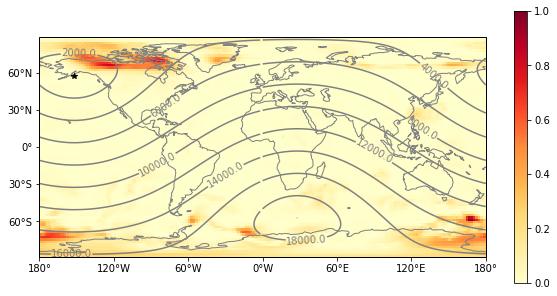

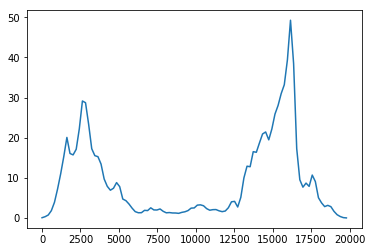

In [113]:
# Test hypothesis about what sets localization
# Need to area weight
# Need equal area proj

NB = 100
Nens = 60
# Pick an ob location
obind = 141
#obind = 344

# "truth"
ii = 0
vYe_t, vYe_coords = mk_yes(ad[ii]['X'],ad[ii]['Xbp'],prox_manager,ad[ii]['grid'])

# Make a map of distances (good for both prior and truth)
var = list(ad[ii]['X'].statevars.keys())[0]
X_lat = ad[ii]['X'].prior_dict[var]['lat']
X_lon = ad[ii]['X'].prior_dict[var]['lon']

# Wrap before computing dists to help with contours below
X_lonw, wrap_lon = cutil.add_cyclic_point(X_lon, coord=grid.lon[0,:], axis=1)
X_latw, wrap_lon = cutil.add_cyclic_point(X_lat, coord=grid.lon[0,:], axis=1)
#distsw = np.array(LMR_utils.haversine(vYe_coords[obind,1], vYe_coords[obind,0],X_lonw,X_latw),dtype=np.float64)
dists = np.array(LMR_utils.haversine(vYe_coords[obind,1], vYe_coords[obind,0],X_lon,X_lat),dtype=np.float64)

# Compute regressions in distance range for two models and save
# "prior"
jj = 1
vYe_p, vYe_coords = mk_yes(ad[jj]['X'],ad[jj]['Xbp'],prox_manager,ad[jj]['grid'])

#rmap_t = 1/(Nens-1)*ad[ii]['Xbp'].dot(vYe_t[obind,:])
#rmap_p = 1/(Nens-1)*ad[jj]['Xbp'].dot(vYe_p[obind,:])
rmap_t = 1/(Nens-1)*ad[ii]['Xbp'].dot(vYe_t[obind,:])/np.var(vYe_t[obind,:])
rmap_p = 1/(Nens-1)*ad[jj]['Xbp'].dot(vYe_p[obind,:])/np.var(vYe_p[obind,:])

# Define a range of distances
drange = np.linspace(0,20000,NB)

# Loop through distance ranges
diffs = (rmap_p-rmap_t)**2#/np.var(vYe_p[obind,:])
r2 = np.flipud(np.reshape(diffs,[grid.nlat,grid.nlon]))
r1 = [] # mean
rv = [] # var
for jj in np.arange(len(drange)-1):
    r1.append( np.sum( r2[ (dists>=drange[jj]) & (dists<drange[jj+1]) ]));
    rv.append( np.var( r2[ (dists>=drange[jj]) & (dists<drange[jj+1]) ]));
    
# Need to normalize by variance!

import cartopy.util as cutil
import cartopy.crs as ccrs
fig = plt.figure(figsize=(10,5))

r2w, wrap_lon = cutil.add_cyclic_point(r2, coord=grid.lon[0,:], axis=1)
#distsw, wrap_lon = cutil.add_cyclic_point(dists, coord=grid.lon[0,:], axis=1)

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
ax.grid(True,which='major',axis='both')
ax.pcolor(wrap_lon,grid.lat[:,0],r2w,cmap='YlOrRd')#,vmin=-5,vmax=1)
ax.coastlines(color='gray')
CS=ax.contour(grid.lon[0,:],grid.lat[:,0],dists,10,colors='gray')
ax.clabel(CS,fmt='%r')

ax.set_xticks([-180,-120,-60,0,60,120,180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.plot(np.mod(vYe_coords[obind,1] - 180.0, 360.0) - 180.0, vYe_coords[obind,0],'k*')

sm = plt.cm.ScalarMappable(cmap='YlOrRd',norm=plt.Normalize(0,1))
sm._A = []
plt.colorbar(sm,ax=ax)

plt.show()

plt.plot(drange[:-1],np.array(r1))
plt.show();



/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


1.2307767195271102


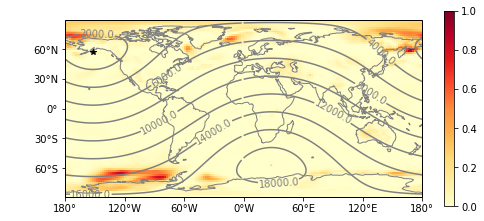

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in greater_equal
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in less
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in greater_equal
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in less
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/nu

27.27383109975595


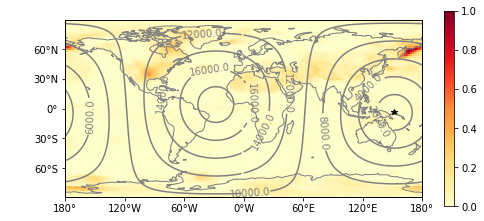

In [96]:
drange,r0 = mkresplot(141)
plt.show()
drange,r1 = mkresplot(418) # eq
plt.show()

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


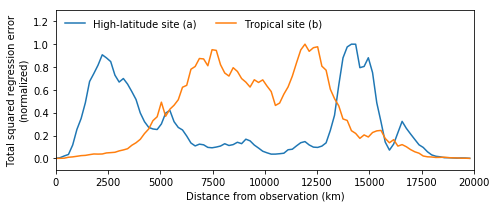

In [97]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

plt.figure(figsize=(7,3))
plt.plot(drange[:-1],np.array(r0)/np.nanmax(np.array(r0)))
plt.plot(drange[:-1],np.array(r1)/np.nanmax(np.array(r1)))
#plt.plot(drange[:-1],np.array(r2))
plt.ylabel('Total squared regression error\n(normalized)')
plt.xlabel('Distance from observation (km)')
plt.xlim([0,20000])
plt.ylim([-.1,1.3])
plt.legend(['High-latitude site (a)', 'Tropical site (b)'],
           frameon=False,loc='upper left',ncol=2)
plt.tight_layout
plt.savefig('/Users/dan/Desktop/Nullspace_Figs/reg_error_rad.pdf')
plt.show()




/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


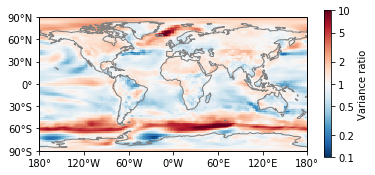

1.0526985269221079
1.1449147856839919


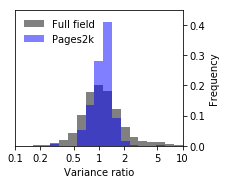

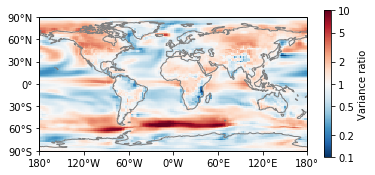

0.9756933705063113
1.0831913529420976


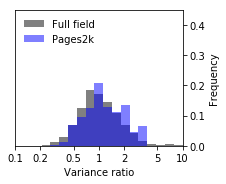

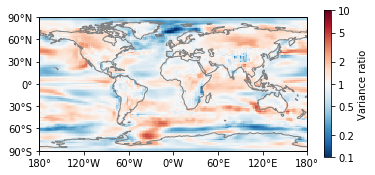

0.9626638148407247
1.0685054881754394


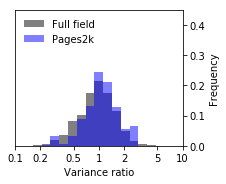

In [87]:
# Inflation plots
# Make log ratio variance plots for all three priors

inds = np.array([[0,1], [0,2], [1,2]])

for i,rr in enumerate(inds):

    r = (np.var(ad[rr[0]]['Xbp'],1)/np.var(ad[rr[1]]['Xbp'],1)).reshape(91,180)

    r2w, wrap_lon = cutil.add_cyclic_point(r, coord=grid.lon[0,:], axis=1)
    #distsw, wrap_lon = cutil.add_cyclic_point(dists, coord=grid.lon[0,:], axis=1)
    
    fig = plt.figure(figsize=(6,3))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
    ax.grid(True,which='major',axis='both')
    cs = ax.pcolor(wrap_lon,grid.lat[:,0],(np.log10(r2w)),cmap='RdBu_r',vmin=-1,vmax=1)
    ax.coastlines(color='gray')

    ax.set_xticks([-180,-120,-60,0,60,120,180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    cbar = plt.colorbar(cs, shrink=.9)#, extend='both')
    cbar.set_ticks(np.log10([0.1,0.5,0.2,1,2,5,10]))
    cbar.ax.set_yticklabels(['0.1','0.5','0.2','1','2','5','10'])
    cbar.set_label('Variance ratio')

    plt.savefig('/Users/dan/Desktop/Nullspace_Figs/var_ratio_' +str(rr[0])  + '-' + str(rr[1])  + '.png',dpi=300,bbox_inches='tight')
    plt.show()
    
    fig = plt.figure(figsize=(3,2.5))
    ax = fig.add_subplot(111)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    plt.hist(np.log10(r.ravel()),bins=np.linspace(-1,1,20),color='gray',alpha=1.,weights=1./len(r.ravel())*np.ones(len(r.ravel())));
    plt.xlim([-1,1])
#    plt.grid()
    plt.xticks(np.log10([0.1,0.5,0.2,1,2,5,10]),['0.1','0.5','0.2','1','2','5','10'])
    plt.ylabel('Frequency')
    plt.xlabel('Variance ratio')
    md = np.log10(np.median(r.ravel()))
#    plt.text(np.log10(1.5),3000,'$\mu$ = '+"{:.2f}".format(10**mn),color='k')
#    plt.tight_layout()

    vYe_p0, vYe_coords0 = mk_yes(ad[rr[0]]['X'],ad[rr[0]]['Xbp'],prox_manager,ad[rr[0]]['grid'])
    vYe_p1, vYe_coords1 = mk_yes(ad[rr[1]]['X'],ad[rr[1]]['Xbp'],prox_manager,ad[rr[1]]['grid'])
    
    cr = np.var(vYe_p0,1)/np.var(vYe_p1,1)
    cmd = np.log10(np.median(cr.ravel()))
    plt.hist(np.log10(cr.ravel()),bins=np.linspace(-1,1,20),color='blue',alpha=0.5,weights=1./len(cr.ravel())*np.ones(len(cr.ravel())));

    mx = 0.45
    
#    plt.plot(np.array([md,md]),np.array([0,mx]),color='k')
#    plt.plot(np.array([cmd,cmd]),np.array([0,mx]),color='b')
    plt.ylim([0,mx])
#    plt.text(np.log10(1.5),0.35,'$\mu$ = '+"{:.2f}".format(10**md),color='k')
#    plt.text(np.log10(1.5),0.3,'Median = '+"{:.2f}".format(10**cmd),color='b')
    print(10**md)
    print(10**cmd)
    plt.legend(['Full field','Pages2k'], frameon=False,loc='upper left')
    
    plt.savefig('/Users/dan/Desktop/Nullspace_Figs/var_ratio_hist_' +str(rr[0])  + '-' + str(rr[1])  + '.png',dpi=300,bbox_inches='tight')
    plt.show()

    
    

In [ ]:
# Sanity check
jj = 35
print(drange[jj])
test = np.zeros((91,180))
test[(dists>=drange[jj]) & (dists<drange[jj+1])]= r2[(dists>=drange[jj]) & (dists<drange[jj+1])]
print(np.sum(test))
plt.pcolor(test);

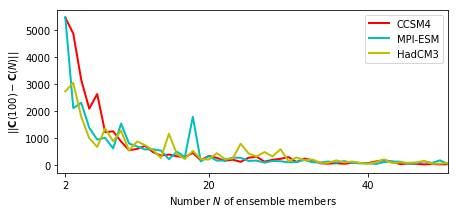

In [112]:
# Is 100 enough for convergence?

plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

plt.figure(figsize=(7,3))
dv = np.empty([3,100])
for mi in np.arange(3):
    Xbp = ad[mi]['Xbp']
    Nens = ad[mi]['grid'].nens
    [u, s, vt] = np.linalg.svd(Xbp,full_matrices=False)
    Wn = np.empty([Nens,Nens])
    # Compute SVs as a function of Nens
    for ii in np.arange(1,Nens):
        W = np.sqrt(1/(ii)) * u.T.dot(Xbp[:,:ii])
        Wn[ii,:] = np.sqrt(np.sum(W*W,1))
    dv[mi,:] = sum((Wn-Wn[-1,:])*(Wn-Wn[-1,:]),1)

plt.plot(np.arange(100)+2,dv.T[:,0],"r",linewidth=2)
plt.plot(np.arange(100)+2,dv.T[:,1],"c",linewidth=2)
plt.plot(np.arange(100)+2,dv.T[:,2],"y",linewidth=2)
#plt.title('Sum of squared differences of EOF weights from 100 ensemble member case')

plt.xlabel('Number $N$ of ensemble members')
plt.xticks([2,20,40,60,80,100])
plt.xlim([1,50])
#plt.ylabel(r'Residual variance (K$^2$)')
plt.ylabel(r'$\|\|\mathbf{C}(100)-\mathbf{C}(N)\|\|$')
plt.legend([model_names[0],model_names[1],model_names[2]],frameon=True)
plt.tight_layout
# I now think this final picture is just the Frobenius distance!
plt.savefig('/Users/dan/Desktop/Nullspace_Figs/converges.pdf',bbox_inches='tight')


In [92]:
#
# specify a localized function for the truth state, and then test its recovery
#

# center point for the function max
var = list(X.statevars.keys())[0]
site_lat = 40.
site_lon = 330.
X_lat = X.prior_dict[var]['lat']
X_lon = X.prior_dict[var]['lon']
# distance from the max
dists = np.array(LMR_utils.haversine(site_lon, site_lat,X_lon,X_lat),dtype=np.float64)

# specify a decay length scale
locRad = 5000.

# gaussian
#gauss = np.exp(-(dists/(locRad/2))**2)
gauss = np.exp((-(dists/(locRad))**2)/2)

In [93]:
# draw new "pseudoproxies" from the known field (hacked from LMR_lite_utils)
#
# this block draws observations from locations of the proxies specified in the config file
#
nlat = grid.nlat
nlon = grid.nlon

vY = []
vR = []
vP = []
vYe = np.zeros([numprox,grid.nens])
vYe_coords = np.zeros([numprox,2])

for proxy_idx, Y in enumerate(prox_manager.sites_assim_proxy_objs()):
    #print(Y.lat,Y.lon)
    # get grid indices
    tmp = grid.lat[:,0]-Y.lat
    itlat = np.argmin(np.abs(tmp))
    tmp = grid.lon[0,:]-Y.lon
    itlon = np.argmin(np.abs(tmp))
    # check that we have the correct point
    #print(itlat,itlon)
    #print('orig:',"%4.1f"%Y.lat,Y.lon)
    #print('check:'"%4.1f"%grid.lat[itlat,0],grid.lon[0,itlon])    
    # the observations
    vY.append(gauss[itlat,itlon])
    vR.append(0.001)
    vP.append(proxy_idx)
    # the ensemble prior estimates
    npos = itlat*nlon + itlon
    vYe[proxy_idx,:] = Xbp[npos,:]
    vYe_coords[proxy_idx,:] = X.coords[npos,:]

print(vYe.shape)
print(vYe_coords.shape)
print(len(vY))
print(len(vP))

(542, 100)
(542, 2)
542
542


In [94]:
# option to change the localization radius in the config file (used by DA code)
print(cfg.core.loc_rad)
cfg_params = LMR_utils.param_cfg_update('core.loc_rad',5000.)
cfg_new = LMR_config.Config(**cfg_params)

print(cfg_new.core.loc_rad)

25000
5000.0


In [95]:
xam,Xap,_ = LMRlite.Kalman_optimal(vY,vR,vYe,Xbp,verbose=True)
xam2,Xap2 = LMRlite.Kalman_ESRF(cfg_new,vY,vR,vYe,Xbp,X=X,vYe_coords=vYe_coords,verbose=True)


 all-at-once solve...

number of obs: 542
number of ensemble members: 100
ndof :100
U :(542, 542)
s :(100,)
V :(100, 100)
recontructing using 99 singular values
min s: 1.3748921585818236e-14
shape of U: (542, 542)
shape of s: (100,)
shape of V: (100, 100)
-----------------------------------------------------
completed in 0.043836116790771484 seconds
-----------------------------------------------------
Ensemble square root filter...
Xb shape: (16922, 100)
X coords shape (16380, 2)
X aug coords shape (16922, 2)
appended state...


/Users/dan/Desktop/LMR_py3/LMR_utils.py:89: RuntimeWarning: invalid value encountered in arcsin
  c = 2 * np.arcsin(np.sqrt(a))
/Users/dan/Desktop/LMR_py3/LMR_DA.py:157: RuntimeWarning: invalid value encountered in less_equal
  ind_inner = np.where(dists <= hlr)    # closest
/Users/dan/Desktop/LMR_py3/LMR_DA.py:158: RuntimeWarning: invalid value encountered in greater
  ind_outer = np.where(dists >  hlr)    # close
/Users/dan/Desktop/LMR_py3/LMR_DA.py:159: RuntimeWarning: invalid value encountered in greater
  ind_out   = np.where(dists >  2.*hlr) # out


-----------------------------------------------------
completed in 8.081465244293213 seconds
-----------------------------------------------------


In [96]:
def mapplot(map,grid):
    fig = plt.figure(figsize=(8,4))
    r2w, wrap_lon = cutil.add_cyclic_point(map, coord=grid.lon[0,:], axis=1)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
    ax.grid(True,which='major',axis='both')
    ax.pcolor(wrap_lon,grid.lat[:,0],r2w,cmap='RdBu_r',vmin=-1,vmax=1)
    ax.coastlines(color='gray')

    ax.set_xticks([-180,-120,-60,0,60,120,180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
#    ax.scatter(vYe_coords[:,1]+2.5,vYe_coords[:,0]+2.5,c='k',s=npp*3,transform=ccrs.PlateCarree(central_longitude=0.))
    sm = plt.cm.ScalarMappable(cmap='RdBu_r')#,norm=plt.Normalize(0,1))
    sm._A = []
    plt.colorbar(sm,ax=ax)
    
    return ax




/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


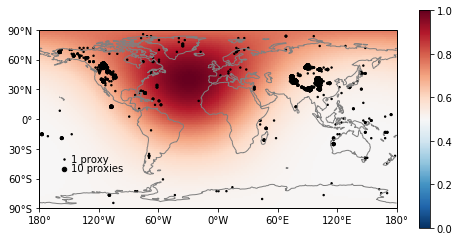

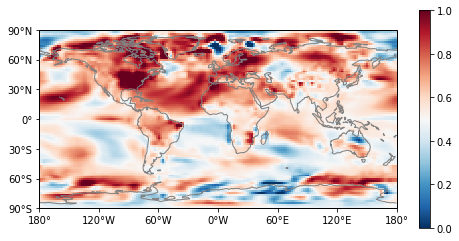

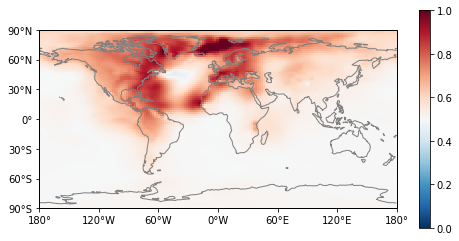

In [97]:
ax=mapplot(gauss,grid)
npp = np.empty([len(vYe_coords),1])
for ii in np.arange(len(vYe_coords)):
    npp[ii] = np.sum((vYe_coords[:,0]==vYe_coords[ii,0]) & 
                    ((vYe_coords[:,1]==vYe_coords[ii,1])))
    
#ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
#gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=0.), draw_labels=True,
#                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
#ax.grid(True,which='major',axis='both')
#ax.coastlines()
csl = 2
xam_lalo = np.reshape(xam,[grid.nlat,grid.nlon])
xam_lalo2 = np.reshape(xam2,[grid.nlat,grid.nlon])
ax.scatter(vYe_coords[:,1]+2.5,vYe_coords[:,0]+2.5,c='k',s=npp*csl,transform=ccrs.PlateCarree(central_longitude=0.),facecolors='none')
ax.scatter(-155,-40,s=1*csl,transform=ccrs.PlateCarree(central_longitude=0.),c='k',facecolors='none')
ax.scatter(-155,-50,s=10*csl,transform=ccrs.PlateCarree(central_longitude=0.),c='k',facecolors='none')
ax.text(-148,-43,'1 proxy')
ax.text(-148,-53,'10 proxies')
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
plt.savefig('/Users/dan/Desktop/Nullspace_Figs/gauss_truth.png',bbox_inches='tight',dpi=300)
mapplot(xam_lalo,grid)
plt.savefig('/Users/dan/Desktop/Nullspace_Figs/gauss_inferred.png',bbox_inches='tight',dpi=300)
mapplot(xam_lalo2,grid)
plt.savefig('/Users/dan/Desktop/Nullspace_Figs/gauss_inferred_5kloc.png',bbox_inches='tight',dpi=300)


